# Quantitative strategy case interview for Dr. Li Zhihuan
## Section 3

In [215]:
import pandas as pd 
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
import statsmodels.api as sm
import zipfile
import io


## Question A

In [216]:
# Load HDB resale transactions data and inflation data from previous section into a pandas DataFrame
df = pd.read_csv('hdb.csv')
dfinflation = pd.read_csv('inflation.csv')

# Perform an inner join based on the 'Year' column
merged_df = pd.merge(dfinflation, df, on='year', how='inner')

# Cast the 'resale_price' and 'CPI' column to integer type
merged_df['resale_price'] = merged_df['resale_price'].astype(float)
merged_df['CPI'] = merged_df['CPI'].astype(float)

# Turn resale rpice into inflation adjusted price in 2014 dollars by using the housing CPI for 2014
merged_df['resale_price'] = merged_df['resale_price'] / merged_df['CPI'] * 113.517

# Print the updated DataFrame
merged_df.head()


,year,CPI,_id,month,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,resale_price,min_storey,max_storey,average_storey,flat_age
0,1990.0,62.102,1,1,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,31.0,IMPROVED,1977.0,16451.209301,10,12,11,13.0
1,1990.0,62.102,2,1,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,31.0,IMPROVED,1977.0,10967.472867,4,6,5,13.0
2,1990.0,62.102,3,1,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,31.0,IMPROVED,1977.0,14623.297156,10,12,11,13.0
3,1990.0,62.102,4,1,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,31.0,IMPROVED,1977.0,10967.472867,7,9,8,13.0
4,1990.0,62.102,5,1,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,73.0,NEW GENERATION,1976.0,86277.453222,4,6,5,14.0


In [217]:
# We shall employ the DiD model for 2 towns, Yishun and Sembawang
did_df = merged_df[(merged_df['town'] == 'YISHUN') | (merged_df['town'] == 'SEMBAWANG')]
did_df.sample(10)

,year,CPI,_id,month,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,resale_price,min_storey,max_storey,average_storey,flat_age
35761,1992.0,65.162,35762,9,YISHUN,4 ROOM,311,YISHUN RING RD,104.0,MODEL A,1987.0,222985.420951,10,12,11,5.0
251143,1999.0,72.747,251144,4,YISHUN,5 ROOM,613,YISHUN ST 61,121.0,IMPROVED,1987.0,496218.483236,1,3,2,12.0
761347,2017.0,102.372,15145,9,YISHUN,4 ROOM,930,YISHUN CTRL 1,104.0,Model A,1993.0,498990.446606,4,6,5,24.0
400694,2003.0,74.307,113499,2,YISHUN,4 ROOM,440,YISHUN AVE 11,104.0,Model A,1988.0,299424.441843,7,9,8,15.0
366036,2002.0,74.558,78841,2,YISHUN,4 ROOM,289,YISHUN AVE 6,103.0,Model A,1987.0,312119.222619,10,12,11,15.0
375786,2002.0,74.558,88591,5,YISHUN,4 ROOM,715,YISHUN ST 71,84.0,Simplified,1987.0,229902.451783,4,6,5,15.0
581913,2009.0,91.254,294718,7,YISHUN,4 ROOM,879,YISHUN ST 81,104.0,Model A,1987.0,426680.813992,4,6,5,22.0
869396,2022.0,106.406,123194,3,YISHUN,4 ROOM,170,YISHUN AVE 7,104.0,Model A,1986.0,477939.364322,13,15,14,36.0
505306,2006.0,77.639,218111,9,YISHUN,4 ROOM,142,YISHUN RING RD,96.0,New Generation,1984.0,261718.247273,1,3,2,22.0
173396,1997.0,71.833,173397,10,YISHUN,5 ROOM,810,YISHUN RING RD,121.0,IMPROVED,1987.0,630535.867916,7,9,8,10.0


In [218]:
# Create dummy variables for treatment and time period (2016)
did_df['treatment_dummy'] = did_df['town'].apply(lambda x: 1 if x == 'YISHUN' else 0)
did_df['post_dummy'] = did_df['year'].apply(lambda x: 1 if x >= 2016 else 0)


# Create interaction term between treatment and time periods
did_df['treatment_post_interaction'] = did_df['treatment_dummy'] * did_df['post_dummy']

# Specify the DiD model
model = sm.OLS(did_df['resale_price'], sm.add_constant(did_df[['treatment_dummy', 'post_dummy', 'treatment_post_interaction', 'floor_area_sqm', 'flat_age', 'average_storey']]))

# Fit the model
results = model.fit()

# Print the estimated coefficients
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           resale_price   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                 2.571e+04
Date:                Wed, 06 Dec 2023   Prob (F-statistic):               0.00
Time:                        21:53:29   Log-Likelihood:            -1.0512e+06
No. Observations:               82419   AIC:                         2.102e+06
Df Residuals:                   82412   BIC:                         2.102e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

C:\Users\lizhi\AppData\Local\Temp\ipykernel_9136\973217322.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  did_df['treatment_dummy'] = did_df['town'].apply(lambda x: 1 if x == 'YISHUN' else 0)
C:\Users\lizhi\AppData\Local\Temp\ipykernel_9136\973217322.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  did_df['post_dummy'] = did_df['year'].apply(lambda x: 1 if x >= 2016 else 0)
C:\Users\lizhi\AppData\Local\Temp\ipykernel_9136\973217322.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy

In [219]:
# Making a quick check on the p-values
for x in range (0, 7):
    print(results.pvalues[x])

0.0
6.2958878217659255e-127
0.0
1.6644438691972224e-80
0.0
1.4611459173928622e-13
2.83365368829321e-180


In [220]:
# Rerun the model with treatment year as 2018
did_df = merged_df[(merged_df['town'] == 'YISHUN') | (merged_df['town'] == 'SEMBAWANG')]

# Create dummy variables for treatment and time period (2018)
did_df['treatment_dummy'] = did_df['town'].apply(lambda x: 1 if x == 'YISHUN' else 0)
did_df['post_dummy'] = did_df['year'].apply(lambda x: 1 if x >= 2018 else 0)

# Create interaction term between treatment and time periods
did_df['treatment_post_interaction'] = did_df['treatment_dummy'] * did_df['post_dummy']

# Specify the DiD model
model = sm.OLS(did_df['resale_price'], sm.add_constant(did_df[['treatment_dummy', 'post_dummy', 'treatment_post_interaction', 'floor_area_sqm', 'flat_age', 'average_storey']]))

# Fit the model
results = model.fit()

# Print the estimated coefficients
print(results.summary())

C:\Users\lizhi\AppData\Local\Temp\ipykernel_9136\930277622.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  did_df['treatment_dummy'] = did_df['town'].apply(lambda x: 1 if x == 'YISHUN' else 0)


                            OLS Regression Results                            
Dep. Variable:           resale_price   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                 2.622e+04
Date:                Wed, 06 Dec 2023   Prob (F-statistic):               0.00
Time:                        21:53:29   Log-Likelihood:            -1.0507e+06
No. Observations:               82419   AIC:                         2.101e+06
Df Residuals:                   82412   BIC:                         2.101e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

C:\Users\lizhi\AppData\Local\Temp\ipykernel_9136\930277622.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  did_df['post_dummy'] = did_df['year'].apply(lambda x: 1 if x >= 2018 else 0)
C:\Users\lizhi\AppData\Local\Temp\ipykernel_9136\930277622.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  did_df['treatment_post_interaction'] = did_df['treatment_dummy'] * did_df['post_dummy']


In [221]:
# Compiling the data to plot the graphs for use in the powerpoint slides
did_chart = did_df[['town', 'year', 'resale_price', 'floor_area_sqm']]
did_chart['price per area'] = did_chart['resale_price'] / did_chart['floor_area_sqm']

median_over_time = did_chart.groupby(['town','year'])['price per area'].median()

median_over_time.columns = ['town', 'year', 'median price']
median_over_time = median_over_time.to_frame()

median_over_time.head()


C:\Users\lizhi\AppData\Local\Temp\ipykernel_9136\3050083705.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  did_chart['price per area'] = did_chart['resale_price'] / did_chart['floor_area_sqm']


price per area
town      year                  
SEMBAWANG 1990.0      608.352011
          1991.0      670.080516
          1992.0      857.426851
          1993.0     1890.633559
          1995.0     2205.970798

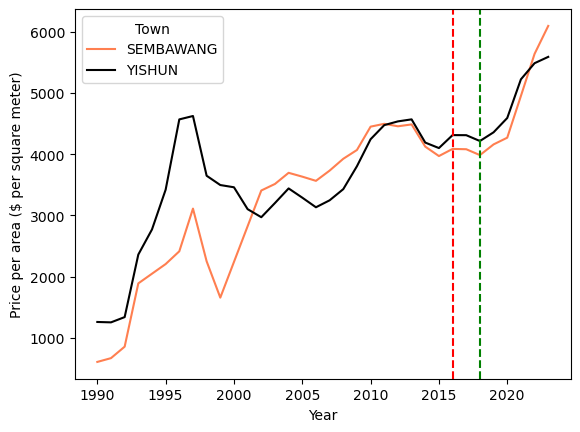

In [222]:
# Plotting resale price per floor area for YISHUN and SEMBAWANG
sns.lineplot(data=median_over_time, x='year', y='price per area', hue='town', palette={'YISHUN': 'black', 'SEMBAWANG':'coral'})


plt.axvline(x=2016, color='red', linestyle='--')
plt.axvline(x=2018, color='green', linestyle='--')

plt.xlabel('Year')
plt.ylabel('Price per area ($ per square meter)')
plt.legend(title='Town')
plt.show()

C:\Users\lizhi\AppData\Local\Temp\ipykernel_9136\995165560.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  did_chart['price per area'] = did_chart['resale_price'] / did_chart['floor_area_sqm']


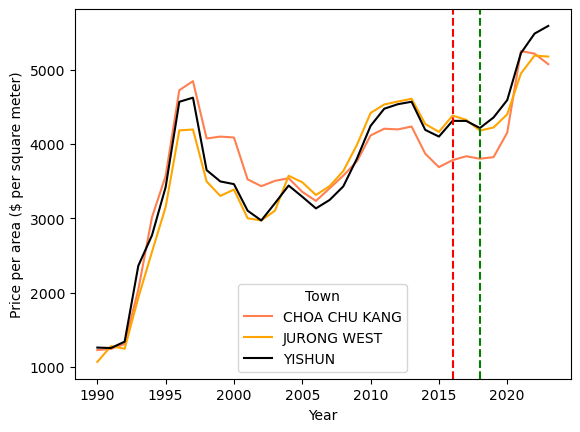

In [223]:
# Plotting resale price per floor area for YISHUN, CCK and JURONG WEST

tempdf = merged_df

# Define the towns to keep
towns_to_keep = ['YISHUN', 'CHOA CHU KANG', 'JURONG WEST']

# Filter the DataFrame to keep rows with specified towns
filtered_df = tempdf[tempdf['town'].isin(towns_to_keep)]

did_chart = filtered_df[['town', 'year', 'resale_price', 'floor_area_sqm']]
did_chart['price per area'] = did_chart['resale_price'] / did_chart['floor_area_sqm']

median_over_time = did_chart.groupby(['town','year'])['price per area'].median()

median_over_time.columns = ['town', 'year', 'median price']
median_over_time = median_over_time.to_frame()

median_over_time.head()

# Creating the plot for the powerpoint slides
sns.lineplot(data=median_over_time, x='year', y='price per area', hue='town', palette={'CHOA CHU KANG': 'coral', 'JURONG WEST': 'orange', 'YISHUN': 'black'})

plt.axvline(x=2016, color='red', linestyle='--')
plt.axvline(x=2018, color='green', linestyle='--')

plt.xlabel('Year')
plt.ylabel('Price per area ($ per square meter)')
plt.legend(title='Town')
plt.show()

# Question B

Question B was answered using graphs obtained from Tableau as it was much much easier and faster to do so. Without the time constraint, the same result could have been obtained with Python.

# Question C

In [224]:
# Load HDB resale transactions data and inflation data from previous section into a pandas DataFrame
df = pd.read_csv('hdb.csv')
dfinflation = pd.read_csv('inflation.csv')

# Perform an inner join based on the 'Year' column
merged_df = pd.merge(dfinflation, df, on='year', how='inner')

# Cast the 'resale_price' and 'CPI' column to integer type
merged_df['resale_price'] = merged_df['resale_price'].astype(float)
merged_df['CPI'] = merged_df['CPI'].astype(float)

# Multiply 'resale_price' with 'Average' divided by 110.66, the housing CPI for 2014
merged_df['resale_price'] = merged_df['resale_price'] / merged_df['CPI'] * 113.517

# Standardising Multi-Generation and Multi Generation
merged_df['flat_type'] = merged_df['flat_type'].replace('MULTI-GENERATION', 'MULTI GENERATION')

# Print the updated DataFrame
merged_df.head()

,year,CPI,_id,month,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,resale_price,min_storey,max_storey,average_storey,flat_age
0,1990.0,62.102,1,1,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,31.0,IMPROVED,1977.0,16451.209301,10,12,11,13.0
1,1990.0,62.102,2,1,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,31.0,IMPROVED,1977.0,10967.472867,4,6,5,13.0
2,1990.0,62.102,3,1,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,31.0,IMPROVED,1977.0,14623.297156,10,12,11,13.0
3,1990.0,62.102,4,1,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,31.0,IMPROVED,1977.0,10967.472867,7,9,8,13.0
4,1990.0,62.102,5,1,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,73.0,NEW GENERATION,1976.0,86277.453222,4,6,5,14.0


In [225]:
# Rerun the model with treatment year as 2016 (DTL2 operational on 27 Dec 2015 )
did_df = merged_df[(merged_df['town'] == 'CHOA CHU KANG') | (merged_df['town'] == 'BUKIT PANJANG')]

# Create dummy variables for treatment and time periods
did_df['treatment_dummy'] = did_df['town'].apply(lambda x: 1 if x == 'BUKIT PANJANG' else 0)
did_df['post_dummy'] = did_df['year'].apply(lambda x: 1 if x >= 2016 else 0)

# Create interaction term between treatment and time periods
did_df['treatment_post_interaction'] = did_df['treatment_dummy'] * did_df['post_dummy']

# Specify the DiD model
model = sm.OLS(did_df['resale_price'], sm.add_constant(did_df[['treatment_dummy', 'post_dummy', 'treatment_post_interaction', 'floor_area_sqm', 'flat_age', 'average_storey']]))

# Fit the model
results = model.fit()

# Print the estimated coefficients
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           resale_price   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                 2.276e+04
Date:                Wed, 06 Dec 2023   Prob (F-statistic):               0.00
Time:                        21:53:31   Log-Likelihood:            -8.2100e+05
No. Observations:               64941   AIC:                         1.642e+06
Df Residuals:                   64934   BIC:                         1.642e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

C:\Users\lizhi\AppData\Local\Temp\ipykernel_9136\370870211.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  did_df['treatment_dummy'] = did_df['town'].apply(lambda x: 1 if x == 'BUKIT PANJANG' else 0)
C:\Users\lizhi\AppData\Local\Temp\ipykernel_9136\370870211.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  did_df['post_dummy'] = did_df['year'].apply(lambda x: 1 if x >= 2016 else 0)
C:\Users\lizhi\AppData\Local\Temp\ipykernel_9136\370870211.py:9: SettingWithCopyWarning: 
A value is trying to be set on

# Question D

In [226]:
# Download the zip file
zip_file_response = requests.get('https://datamall.lta.gov.sg/content/dam/datamall/datasets/Facts_Figures/Vehicle%20Registration/COE%20Bidding%20Results.zip')

# Extract the zip file in memory
with zipfile.ZipFile(io.BytesIO(zip_file_response.content), 'r') as zip_file:
    # Find the CSV file within the zip file
    csv_file_name = "COE Bidding Results/M11-coe_results.csv"
    
    # Read the CSV file into a DataFrame
    coe_df = pd.read_csv(zip_file.open(csv_file_name))

coe_df.head()


,month,bidding_no,vehicle_class,quota,bids_success,bids_received,premium
0,2010-01,1,Category A,1152,1145,1342,18502
1,2010-01,1,Category B,687,679,883,19190
2,2010-01,1,Category C,173,173,265,19001
3,2010-01,1,Category D,373,365,509,889
4,2010-01,1,Category E,586,567,1011,19889


In [227]:
# Split Cat A and Cat D prices into 2 dfs
coe_a = coe_df[coe_df['vehicle_class'].isin(['Category A'])]
coe_d = coe_df[coe_df['vehicle_class'].isin(['Category D'])]

print(coe_a)
print(coe_d)

        month  bidding_no vehicle_class  quota  bids_success bids_received  \
0     2010-01           1    Category A   1152          1145          1342   
5     2010-01           2    Category A   1151          1149          1673   
10    2010-02           1    Category A   1154          1153          1326   
15    2010-02           2    Category A   1148          1148          1493   
20    2010-03           1    Category A   1148          1141          1758   
...       ...         ...           ...    ...           ...           ...   
1615  2023-09           2    Category A    651           635           864   
1620  2023-10           1    Category A    785           779         1,039   
1625  2023-10           2    Category A    797           791         1,028   
1630  2023-11           1    Category A    924           915          1165   
1635  2023-11           2    Category A    925           925          1291   

      premium  
0       18502  
5       20501  
10      19989  

In [228]:
# Calculate the average premium for each month as there are 2 auctions per month
coe_a = coe_a.groupby('month')['premium'].mean()
coe_d = coe_d.groupby('month')['premium'].mean()
print(coe_a)
print(coe_d)

month
2010-01     19501.5
2010-02     20164.5
2010-03     24595.5
2010-04     32000.5
2010-05     26745.5
             ...   
2023-07     96101.0
2023-08     99749.5
2023-09    103000.0
2023-10    105000.0
2023-11     90345.0
Name: premium, Length: 164, dtype: float64
month
2010-01      870.5
2010-02      926.5
2010-03     1179.5
2010-04     1237.0
2010-05     1282.0
            ...   
2023-07    10295.5
2023-08    11451.5
2023-09    10800.5
2023-10    11028.5
2023-11    10445.0
Name: premium, Length: 164, dtype: float64


In [229]:
coe_a.head()

month
2010-01    19501.5
2010-02    20164.5
2010-03    24595.5
2010-04    32000.5
2010-05    26745.5
Name: premium, dtype: float64

In [230]:
# Convert the Series to a DataFrame
coe_a2 = coe_a.to_frame().reset_index(drop=False)
coe_d2 = coe_d.to_frame().reset_index(drop=False)


coe_a2.head()

,month,premium
0,2010-01,19501.5
1,2010-02,20164.5
2,2010-03,24595.5
3,2010-04,32000.5
4,2010-05,26745.5


In [231]:
# Create a df for the regression analysis
reg_df = merged_df

reg_df.head()

,year,CPI,_id,month,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,resale_price,min_storey,max_storey,average_storey,flat_age
0,1990.0,62.102,1,1,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,31.0,IMPROVED,1977.0,16451.209301,10,12,11,13.0
1,1990.0,62.102,2,1,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,31.0,IMPROVED,1977.0,10967.472867,4,6,5,13.0
2,1990.0,62.102,3,1,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,31.0,IMPROVED,1977.0,14623.297156,10,12,11,13.0
3,1990.0,62.102,4,1,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,31.0,IMPROVED,1977.0,10967.472867,7,9,8,13.0
4,1990.0,62.102,5,1,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,73.0,NEW GENERATION,1976.0,86277.453222,4,6,5,14.0


In [232]:
# Filter the transaction data for the towns chosen and to match the COE data

reg_df = reg_df[reg_df['year'] >= 2010]
reg_df = reg_df[reg_df['town'].isin(['QUEENSTOWN', 'SENGKANG'])]

In [233]:
# Cast the 'year' column to integer then to str
reg_df['year'] = reg_df['year'].astype(int)
reg_df['year'] = reg_df['year'].astype(str)

In [234]:
# Concatenate 'year' and 'month' columns with appropriate formatting
reg_df['year_month'] = reg_df.apply(lambda row: f"{row['year']}-{row['month']:02d}" if row['month'] < 10 else f"{row['year']}-{row['month']}", axis=1)

In [235]:
# Add a new column 'resale_price_per_value' by dividing 'resale_price' by 'floor_area'
reg_df['price_per_area'] = reg_df['resale_price'] / reg_df['floor_area_sqm']

reg_df.sample(5)

,year,CPI,_id,month,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,resale_price,min_storey,max_storey,average_storey,flat_age,year_month,price_per_area
879852,2022,106.406,133650,8,SENGKANG,3 ROOM,209B,COMPASSVALE LANE,67.0,Model A,2011.0,460870.101310,13,15,14,11.0,2022-08,6878.658229
886694,2022,106.406,140492,11,SENGKANG,5 ROOM,290C,COMPASSVALE CRES,110.0,Improved,2001.0,605958.836908,10,12,11,21.0,2022-11,5508.716699
904039,2023,110.660,157837,5,QUEENSTOWN,4 ROOM,18A,HOLLAND DR,92.0,Model A,2012.0,849377.155250,4,6,5,11.0,2023-05,9232.360383
879905,2022,106.406,133703,8,SENGKANG,4 ROOM,210B,COMPASSVALE LANE,93.0,Model A,2013.0,585475.721294,10,12,11,9.0,2022-08,6295.437863
868787,2022,106.406,122585,3,SENGKANG,4 ROOM,304A,ANCHORVALE LINK,90.0,Model A,2002.0,443681.353458,4,6,5,20.0,2022-03,4929.792816


In [236]:
# Creating the 2 df for regression analysis of Cat A and Cat D prices with respect to resale prices
reg_q = reg_df[reg_df['town'] == 'QUEENSTOWN']
reg_s = reg_df[reg_df['town'] == 'SENGKANG']

reg_s_a = coe_a2.merge(reg_s, left_on='month', right_on='year_month')
reg_s_d = coe_d2.merge(reg_s, left_on='month', right_on='year_month')

reg_q_a = coe_a2.merge(reg_q, left_on='month', right_on='year_month')
reg_q_d = coe_d2.merge(reg_q, left_on='month', right_on='year_month')

reg_s_a['distance_to_merlion'] = 11930
reg_s_d['distance_to_merlion'] = 11930

reg_q_a['distance_to_merlion'] = 6500
reg_q_d['distance_to_merlion'] = 6500

reg_cat_a = reg_s_a.append(reg_q_a)
reg_cat_d = reg_s_d.append(reg_q_d)

C:\Users\lizhi\AppData\Local\Temp\ipykernel_9136\2688164208.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reg_cat_a = reg_s_a.append(reg_q_a)
C:\Users\lizhi\AppData\Local\Temp\ipykernel_9136\2688164208.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reg_cat_d = reg_s_d.append(reg_q_d)


In [237]:
reg_cat_a.head()

,month_x,premium,year,CPI,_id,month_y,town,flat_type,block,street_name,...,flat_model,lease_commence_date,resale_price,min_storey,max_storey,average_storey,flat_age,year_month,price_per_area,distance_to_merlion
0,2010-01,19501.5,2010,93.299,311217,1,SENGKANG,4 ROOM,305C,ANCHORVALE LINK,...,Model A,2001.0,427062.101416,10,12,11,9.0,2010-01,4745.134460,11930
1,2010-01,19501.5,2010,93.299,311218,1,SENGKANG,4 ROOM,307A,ANCHORVALE RD,...,Model A,2001.0,401511.377400,1,3,2,9.0,2010-01,4461.237527,11930
2,2010-01,19501.5,2010,93.299,311219,1,SENGKANG,4 ROOM,307C,ANCHORVALE RD,...,Model A,2001.0,444095.917427,16,18,17,9.0,2010-01,4934.399083,11930
3,2010-01,19501.5,2010,93.299,311220,1,SENGKANG,4 ROOM,290B,COMPASSVALE CRES,...,Model A,2001.0,401511.377400,10,12,11,9.0,2010-01,4461.237527,11930
4,2010-01,19501.5,2010,93.299,311221,1,SENGKANG,4 ROOM,295A,COMPASSVALE CRES,...,Model A,2002.0,408811.584261,4,6,5,8.0,2010-01,4542.350936,11930


In [238]:
# Create interaction term between treatment and time periods
reg_cat_a['distance_premium'] = reg_cat_a['distance_to_merlion'] * reg_cat_a['premium']

# Specify the regression model
model = sm.OLS(reg_cat_a['price_per_area'], sm.add_constant(reg_cat_a[['distance_premium','average_storey', 'flat_age', 'premium', 'distance_to_merlion']]))

# Fit the model
results = model.fit()

# Print the estimated coefficients
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         price_per_area   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                 1.905e+04
Date:                Wed, 06 Dec 2023   Prob (F-statistic):               0.00
Time:                        21:53:32   Log-Likelihood:            -2.5409e+05
No. Observations:               31539   AIC:                         5.082e+05
Df Residuals:                   31533   BIC:                         5.082e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1.272e+04    

In [239]:
# Create interaction term between treatment and time periods
reg_cat_d['distance_premium'] = reg_cat_d['distance_to_merlion'] * reg_cat_d['premium']

# Specify the regression model
model = sm.OLS(reg_cat_d['price_per_area'], sm.add_constant(reg_cat_d[['distance_premium','average_storey', 'flat_age', 'premium', 'distance_to_merlion']]))

# Fit the model
results = model.fit()

# Print the estimated coefficients
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         price_per_area   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                 2.397e+04
Date:                Wed, 06 Dec 2023   Prob (F-statistic):               0.00
Time:                        21:53:32   Log-Likelihood:            -2.5130e+05
No. Observations:               31539   AIC:                         5.026e+05
Df Residuals:                   31533   BIC:                         5.027e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1.224e+04    

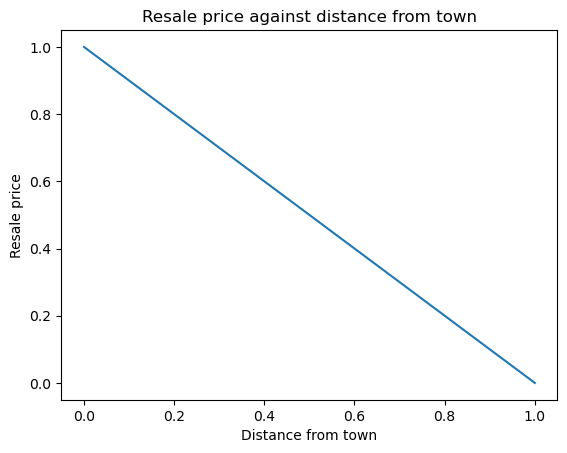

In [240]:
# Creating visual aid for power point slides
import matplotlib.pyplot as plt

# Define the x and y values for the line
x = [0, 1]
y = [1, 0]

# Plot the downward sloping line
plt.plot(x, y)

# Add labels and title
plt.xlabel('Distance from town')
plt.ylabel('Resale price')
plt.title('Resale price against distance from town')

# Display the plot
plt.show()